## Setup

### Imports

In [1]:
import numpy as np #importing libraries
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
from imageio import *
import torch
from skimage.transform import resize
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes, RGBAxes
from torchvision.models import *
from torchvision.datasets import MNIST,KMNIST,FashionMNIST
from skimage.util import montage

In [2]:
!pip install wandb #installing weight and bias library
import wandb as wb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [3]:
def plot(x): #defining a plotting function
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy() #convert the tensor to a np array after moving it to CPU and detaching from the graph

    fig, ax = plt.subplots() #creates a figure and subplot
    im = ax.imshow(x, cmap = 'gray') #gray colormap
    ax.axis('off') #hides the axis
    fig.set_size_inches(5, 5) #size, 5x5
    plt.show()

In [4]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0) #pad the input array on the second and third dimensions (padding after the first dimension)
    plot(montage(x)) #plot a montage of the padded array

In [5]:
b = 1000 #batch size

def get_batch(mode):
    if mode == "train":  #fetches a batch of data (training)
        r = np.random.randint(X.shape[0]-b) #random starting index
        x = X[r:r+b,:] #slicing the training data and labels for a batch
        y = Y[r:r+b]
    elif mode == "test": #fetches a batch of data (testing)
        r = np.random.randint(X_test.shape[0]-b) #andom starting index for testing data
        x = X_test[r:r+b,:] #slicing the testing data and labels for a batch
        y = Y_test[r:r+b]
    return x,y #returns data and labels batch


## MNIST
    

### Load Data

In [6]:
# #MNIST
train_set = MNIST('./data', train=True, download=True) #downloading the MNIST training set
test_set  = MNIST('./data', train=False, download=True) #downloading the MNIST test set

#KMNIST
# train_set = KMNIST('./data', train=True, download=True)
# test_set =  KMNIST('./data', train=False, download=True)

# Fashion MNIST
# train_set = FashionMNIST('./data', train=True, download=True)
# test_set =  FashionMNIST('./data', train=False, download=True)

100%|██████████| 9912422/9912422 [05:05<00:00, 32457.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 130954.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:50<00:00, 32669.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 6689090.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
X = train_set.data.numpy()  #convert train set images to NumPy arrays
X_test = test_set.data.numpy()  #convert test set images to NumPy arrays
Y = train_set.targets.numpy()  #convert train set labels to NumPy arrays
Y_test = test_set.targets.numpy()  #convert test set labels to NumPy arrays

X = X[:, None, :, :] / 255  #add channel dimension to train set and normalize
X_test = X_test[:, None, :, :] / 255  #add channel dimension to test set and normalize

In [8]:
X.shape #shows the shape of X (60000 28x28 grayscale images)

(60000, 1, 28, 28)

In [9]:
Y[50000] #label of the 50001 image

3

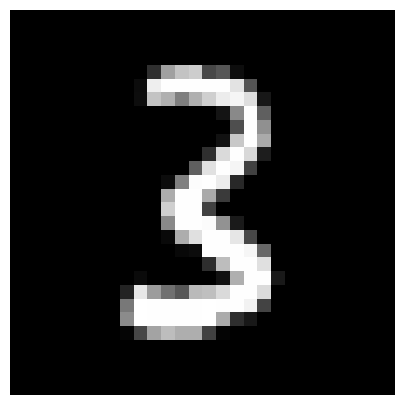

In [10]:
plot(X[50000,0,:,:]) #plots the 50001 image from the dataset

In [11]:
Y[100] #label of the 101 image

5

In [12]:
X.shape #shape of X

(60000, 1, 28, 28)

In [13]:
X[0:25,0,:,:].shape #shape of the first 25 images (all 28x28)

(25, 28, 28)

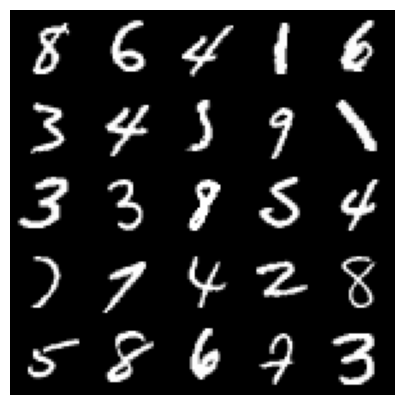

In [14]:
montage_plot(X[125:150,0,:,:]) #montage plot of images from index 125 to 149

In [15]:
X.shape[0] #number of training images (first dimension)

60000

In [16]:
X_test.shape #shape of test set

(10000, 1, 28, 28)

In [17]:
X.shape[0] #number of training images

60000

In [18]:
X_test.shape[0] #number of test images

10000

In [19]:
def GPU(data): #function to convert data to a CUDA tensor for GPU processing, without gradient tracking
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [20]:
#transfer the datasets to GPU for faster computation
X = GPU_data(X)       #transfer training images
Y = GPU_data(Y)       #transfer training labels
X_test = GPU_data(X_test)  #transfer test images
Y_test = GPU_data(Y_test)  #transfer test labels

In [21]:
X = X.reshape(X.shape[0],784) #reshape training images
X_test = X_test.reshape(X_test.shape[0],784) #reshape test images

In [22]:
X.shape #outputs the shape of X (note: 784 features each since we flattened 28x28 to 784)

torch.Size([60000, 784])


### Classifier


In [23]:
x,y = get_batch('train') #retreive a batch of training data

In [24]:
x.shape #check the shape of tensor x

torch.Size([1000, 784])

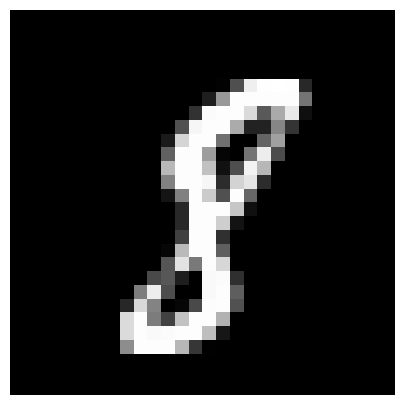

In [25]:

plot(x[0].reshape(28,28)) #plot first image (reshaped to 28x28 pixels)

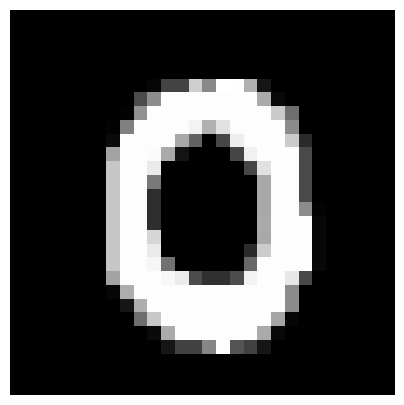

In [26]:
plot(x[1].reshape(28,28)) #plot second image (reshaped to 28x28 pixels)

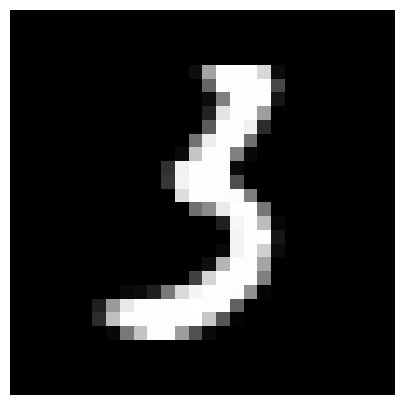

In [27]:
plot(x[2].reshape(28,28)) #plot third image (reshaped to 28x28 pixels)

In [28]:
y[:10] #display the labels for the first ten images in the dataset

tensor([8., 0., 3., 3., 7., 0., 6., 1., 8., 9.], device='cuda:0')

In [29]:
W = GPU(np.random.randn(784,10)) #initialize a weights matrix with random values and transfer it to the GPU

In [30]:
x.shape, W.shape #shows the shape of the data and weights tensor

(torch.Size([1000, 784]), torch.Size([784, 10]))

In [31]:
torch.matmul(x,W).shape #do matrix multiplication between x and W and display its shape

torch.Size([1000, 10])

In [32]:
(x@W).shape #do matrix multiplication between x and W and display its shape

torch.Size([1000, 10])

In [33]:
%%timeit
x@W #checks the time need to do matrix multiplication between x and W

20.8 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
x@W #displays matrix multiplication between x and W

tensor([[ -8.4163,  -2.1347,  -6.9144,  ..., -13.4289,   3.0256,   7.2114],
        [ -0.3196,  -4.7765,  -1.2067,  ...,  -3.7192, -10.5794,  29.2835],
        [-14.7503,  -1.5688,  -6.7629,  ...,  -4.5060,  -8.4588,   3.0070],
        ...,
        [  0.9814,  -4.5946,  -6.1425,  ...,  -8.0906,   2.1497,   8.1924],
        [-15.3044,   6.6253,  -2.8462,  ...,  -3.8803,   7.8523,   7.7576],
        [-13.8258,   1.4453,  -1.1059,  ...,  -3.3553,  -4.4012,   5.1266]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [35]:
y2 = x@W #sets y2=matrix multiplication between x and W

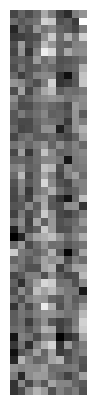

In [36]:
plot(y2[:50]) #plots first 50 entries in y2

In [37]:
y #outputs y

tensor([8., 0., 3., 3., 7., 0., 6., 1., 8., 9., 7., 4., 1., 7., 4., 7., 6., 4.,
        7., 2., 9., 2., 9., 5., 3., 7., 0., 0., 3., 5., 4., 6., 5., 7., 6., 3.,
        7., 5., 0., 0., 1., 0., 2., 8., 3., 7., 4., 6., 5., 5., 6., 3., 7., 5.,
        0., 8., 1., 7., 2., 2., 3., 9., 4., 9., 5., 4., 6., 9., 7., 7., 8., 4.,
        9., 2., 8., 6., 7., 9., 7., 6., 0., 0., 1., 8., 3., 7., 5., 9., 2., 5.,
        8., 2., 0., 0., 9., 0., 6., 5., 0., 4., 9., 7., 1., 2., 1., 8., 8., 0.,
        4., 9., 3., 5., 2., 6., 1., 1., 2., 6., 6., 8., 5., 3., 6., 5., 7., 6.,
        4., 8., 8., 5., 1., 9., 8., 4., 0., 0., 5., 8., 9., 6., 4., 7., 1., 2.,
        9., 7., 2., 9., 1., 0., 9., 8., 6., 9., 7., 8., 9., 3., 0., 9., 4., 0.,
        6., 4., 1., 9., 7., 0., 3., 5., 8., 9., 9., 9., 6., 5., 3., 4., 9., 6.,
        0., 9., 5., 5., 7., 9., 1., 8., 6., 8., 1., 7., 0., 7., 9., 0., 3., 8.,
        3., 6., 4., 1., 4., 4., 0., 3., 6., 3., 2., 4., 5., 6., 4., 5., 4., 1.,
        0., 9., 2., 6., 0., 0., 1., 6., 

In [38]:
y.shape #shows the shape of y

torch.Size([1000])

In [39]:
def one_hot(y):
    y2 = GPU_data(torch.zeros((y.shape[0],10))) #create a one-hot encoded tensor with zeros based on the length of y and number of classes (10)
    for i in range(y.shape[0]): #loop over all samples in y
        y2[i,int(y[i])] = 1 #set the appropriate index for each sample to 1 for one-hot encoding
    return y2 #return the one-hot encoded tensor

In [40]:
one_hot(y) #one-hot encode y

<ipython-input-19-3ed6eaf52084>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], device='cuda:0')

In [41]:
torch.argmax(y2,1) #find the index of the maximum value in each row of y2

tensor([4, 9, 3, 9, 4, 4, 3, 9, 9, 5, 5, 5, 8, 8, 8, 9, 9, 4, 4, 4, 4, 1, 4, 5,
        9, 4, 4, 3, 4, 5, 1, 0, 4, 5, 9, 4, 3, 3, 4, 9, 9, 9, 9, 5, 5, 1, 4, 9,
        5, 3, 5, 5, 1, 5, 3, 9, 9, 5, 9, 9, 5, 5, 4, 4, 5, 5, 9, 7, 4, 5, 1, 5,
        4, 9, 4, 5, 4, 9, 4, 9, 4, 9, 9, 9, 3, 7, 4, 3, 3, 7, 2, 5, 5, 5, 4, 5,
        3, 9, 5, 9, 8, 4, 9, 4, 9, 4, 4, 9, 4, 1, 4, 7, 9, 3, 9, 9, 9, 9, 9, 9,
        6, 4, 9, 5, 5, 5, 1, 9, 9, 9, 9, 9, 4, 5, 4, 7, 5, 4, 4, 9, 0, 8, 9, 9,
        4, 1, 9, 4, 9, 4, 4, 5, 9, 5, 1, 4, 4, 8, 4, 3, 4, 5, 9, 3, 8, 8, 4, 4,
        4, 9, 4, 4, 4, 5, 9, 5, 5, 5, 4, 9, 5, 7, 5, 4, 4, 4, 9, 5, 9, 9, 8, 9,
        4, 6, 4, 4, 9, 5, 3, 9, 5, 9, 4, 3, 4, 9, 9, 8, 9, 8, 1, 9, 8, 9, 9, 2,
        4, 5, 9, 2, 5, 5, 4, 5, 9, 5, 9, 5, 5, 9, 2, 9, 9, 4, 4, 4, 5, 5, 4, 4,
        3, 7, 4, 4, 9, 5, 4, 9, 5, 9, 5, 4, 4, 5, 4, 5, 4, 5, 5, 5, 9, 5, 9, 4,
        9, 9, 5, 5, 5, 4, 9, 4, 4, 9, 5, 7, 4, 9, 5, 4, 4, 6, 9, 1, 4, 9, 5, 9,
        8, 9, 9, 4, 4, 9, 4, 1, 9, 4, 4,

In [42]:
torch.sum(y == torch.argmax(y2,1))/b #calculate and print the accuracy of predictions (correct predictions divided by total predictions)

tensor(0.1040, device='cuda:0')

In [43]:
X.shape #print the shape of the X tensor

torch.Size([60000, 784])

In [44]:
X@W #perform matrix multiplication between X and W

tensor([[ -8.9602, -11.6886, -18.2508,  ...,   5.8545,   1.5831,  22.0147],
        [ -7.3796,  -1.1365,  -4.8942,  ...,   2.5616, -10.0333,   6.0408],
        [ -0.4163,   3.0897,   1.8347,  ...,  -3.3288,  -4.8236,   1.3003],
        ...,
        [ -8.4509,  -0.5832,  -8.9533,  ...,   9.4327,   6.6373,   7.3735],
        [ -7.2510,  -0.3089,  -2.3571,  ...,  -9.2618,  12.2128,   7.5259],
        [  3.3952,   2.2985,  -0.3164,  ...,   2.3271,   6.9493,  -4.2347]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [45]:
torch.argmax(X@W,1) #get the predicted class indices from the logits

tensor([9, 4, 5,  ..., 5, 8, 5], device='cuda:0')

In [46]:
Y #displau y (the actual class labels)

tensor([5., 0., 4.,  ..., 5., 6., 8.], device='cuda:0')

In [47]:
torch.sum(torch.argmax(X@W,1) == Y)/60000 #compute the accuracy by comparing predicted classes to actual labels, then dividing by total number of samples

tensor(0.0964, device='cuda:0')

In [48]:
X@W ##perform matrix multiplication between X and W (obtain logits for class predictions)

tensor([[ -8.9602, -11.6886, -18.2508,  ...,   5.8545,   1.5831,  22.0147],
        [ -7.3796,  -1.1365,  -4.8942,  ...,   2.5616, -10.0333,   6.0408],
        [ -0.4163,   3.0897,   1.8347,  ...,  -3.3288,  -4.8236,   1.3003],
        ...,
        [ -8.4509,  -0.5832,  -8.9533,  ...,   9.4327,   6.6373,   7.3735],
        [ -7.2510,  -0.3089,  -2.3571,  ...,  -9.2618,  12.2128,   7.5259],
        [  3.3952,   2.2985,  -0.3164,  ...,   2.3271,   6.9493,  -4.2347]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [49]:
W.shape #prints the shape of W (the weights tensor)

torch.Size([784, 10])

In [50]:
W[:,0].shape #print the shape of the weights for the first class after slicing

torch.Size([784])

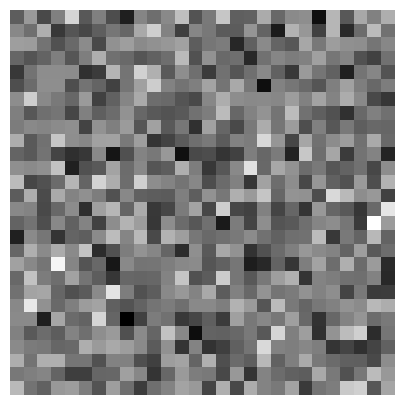

In [51]:
plot(W[:,0].reshape(28,28)) #weights for the first class as a 28x28 image

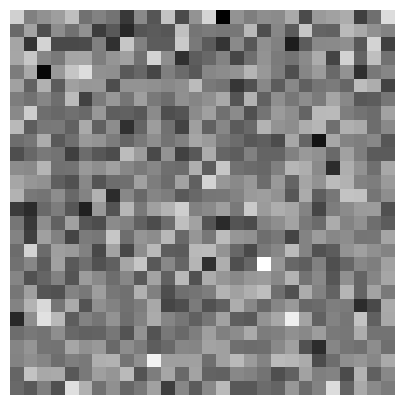

In [52]:
plot(W[:,2].reshape(28,28)) #weights for the second class as a 28x28 image

In [53]:
W.shape #prints the shape of W

torch.Size([784, 10])

In [54]:
(W.T).shape #check the shape of the transposed weight matrix

torch.Size([10, 784])

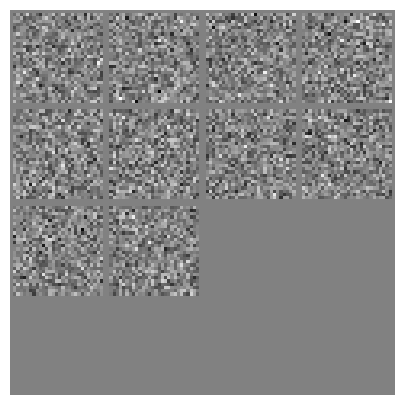

In [55]:
montage_plot((W.T).reshape(10,28,28).cpu().detach().numpy()) #create a montage of the weights for each class after reshaping and converting to a NumPy array

In [56]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None]) #apply the softmax function to an input tensor x
    s = s1 / s1.sum(1)[:,None] #divide by the sum of the exponentials for the softmax
    return s

In [57]:
def cross_entropy(outputs, labels):
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0] #compute cross-entropy loss from model's outputs and true labels

In [58]:
def acc(out,y):
    return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0] #alculate accuracy by comparing predicted class (max probability) with true labels

In [59]:
def get_batch(mode):
    b = c.b #assign batch size from an external variable 'c.b'
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) #select a random batch of data from the training set
        x = X[r:r+b,:] #data batch
        y = Y[r:r+b] #labels batch
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b) #select a random batch of data from the testing set
        x = X_test[r:r+b,:] #data batch
        y = Y_test[r:r+b] #labels batch
    return x,y

In [60]:
def model(x,w): #perform a model prediction using matrix multiplication of input x and weights w

    return x@w[0]

In [61]:
def gradient_step(w):

    w[0].data = w[0].data - c.L*w[0].grad.data #adjust weights with learning rate and gradient

    w[0].grad.data.zero_() #reset gradients to zero for the next update

In [62]:
def make_plots():

    acc_train = acc(model(x,w),y) #get training accuracy

    xt,yt = get_batch('test') #get a test batch

    acc_test = acc(model(xt,w),yt) #get testing accuracy

    wb.log({"acc_train": acc_train, "acc_test": acc_test}) #log accuracies

In [63]:
def Truncated_Normal(size):

    u1 = torch.rand(size)*(1-np.exp(-2)) + np.exp(-2) #uniform distribution adjustment
    u2 = torch.rand(size) #uniform distribution sample
    z  = torch.sqrt(-2*torch.log(u1)) * torch.cos(2*np.pi*u2) #Box-Muller transform

    return z

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-19-3ed6eaf52084>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))


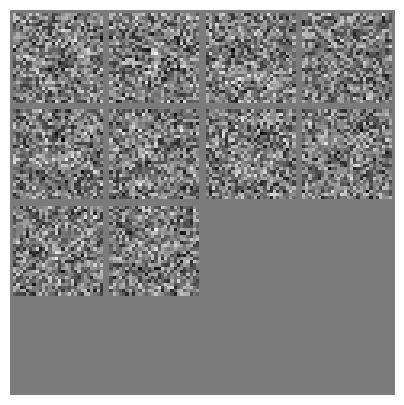

acc_test,▁▁▂▃▃▃▅▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇█▇
acc_train,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇████████████
acc_test,0.80078
acc_train,0.70996


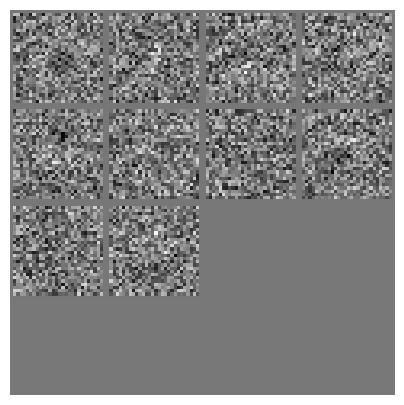

acc_test,▁▂▃▄▅▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▆▆▆▇▇▆▇▇▆▆▆▇▇▇▇▇▇███
acc_train,▁▁▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▆▇▆▇▆▇▇▇█▇▇▇▇████▇
acc_test,0.69336
acc_train,0.66113


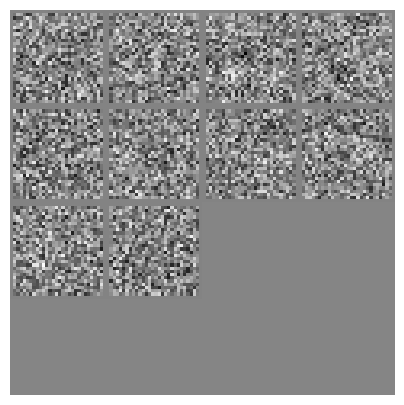

In [64]:
for run in range(3):

    wb.init(project="Simple_Linear_SGD_123"); #new Weights & Biases project
    c = wb.config #configuration settings from Weights & Biases

    #set learning rate, batch size, and number of epochs from the Weights & Biases configuration
    c.L = 0.1
    c.b = 1024
    c.epochs = 10000

    w = [GPU(Truncated_Normal((784,10)))] #initialize weights with samples from a truncated normal distribution

    for i in range(c.epochs): #start the training loop over the number of epochs

        x,y = get_batch('train') #get a batch of training data

        out = model(x,w) #model's predictions for the current batch

        loss = cross_entropy(softmax(out),y) #calculate the cross-entropy loss between predictions and true labels

        loss.backward() #perform back propagation to calculate gradients

        gradient_step(w) #update the model's weights

        make_plots() #make and log plots for tracking

        if (i+1) % 10000 == 0: montage_plot((w[0].T).reshape(10,28,28).cpu().detach().numpy()) #occasionally plot the weights to visualize the learning progress

In [ ]:
for run in range(100): #Cannot run this code, timed out after an hour and a half

    wb.init(project="Simple_Linear_Adam_2"); #new Weights & Biases project
    c = wb.config #Weights & Biases configuration

    #set learning rate, batch size, and number of epochs from the Weights & Biases configuration
    c.L = 0.01
    c.b = 1024
    c.epochs = 100000

    w = [GPU(Truncated_Normal((784,10)))] #model weights with truncated normal distribution and move to GPU

    optimizer = torch.optim.Adam(w, lr=c.L) #Adam optimizer with the weights and learning rate

    for i in range(c.epochs): #training loop for the number of epochs specified

        x,y = get_batch('train') #get a batch of training data

        loss = cross_entropy(softmax(model(x,w)),y) #model's predictions and the corresponding loss

        optimizer.zero_grad() #reset gradients to zero before backpropagation
        loss.backward() #gradient of the loss with respect to the model parameters
        optimizer.step() #update the model parameters

        wb.log({"loss": loss}) #log the loss value to Weights & Biases

        make_plots() #generate and log plots after certain number of epochs

        if i % 10000 == 0 : montage_plot((w[0].T).reshape(10,28,28).cpu().detach().numpy()) #every 10,000 epochs, visualize the model weights


### Autoencoder


In [65]:
def get_batch(mode):
    b = 1024 #batch size
    if mode == "train": #random indices for batch selection are generated (train)
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b] #batch of training data and corresponding labels are returned
    elif mode == "test": #random indices for batch selection are generated (test)
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b] #batch of training data and corresponding labels are returned
    return x,y

In [66]:
X = X.reshape(X.shape[0],1,28,28) #reshape the input tensors to have a single channel and a 28x28 shape
X_test = X_test.reshape(X_test.shape[0],1,28,28)

In [67]:
import torchvision #import PyTorch and functional API for neural network layers
from torch.nn.functional import *

In [68]:
X = torchvision.transforms.functional.normalize(X,0.5,0.5) #normalize the data by centering around 0.5 with a range of 0.5
X_test = torchvision.transforms.functional.normalize(X_test,0.5,0.5)

In [69]:
def Encoder(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1))) #apply convolution and ReLU activation
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1))) #convolution and ReLU
    x = x.view(x.size(0), 6272) #flatten the feature maps
    x = linear(x,w[2]) #apply a linear transformation
    return x

In [70]:
def Decoder(x,w):
    x = linear(x,w[3]) #apply a linear transformation
    x = x.view(x.size(0), 128, 7, 7) #reshape to the expected size for deconvolution
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1))) #deconvolution and ReLU
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1))) #final deconvolution and tanh activation
    return x

In [71]:
def Autoencoder(x,w): #pass input x through the encoder and decoder to reconstruct the input
    return Decoder(Encoder(x,w),w)

In [72]:
num_steps = 1000 #set the number of steps, batch size, and learning rate for training
batch_size = 512
learning_rate = 1e-3

In [73]:
from scipy import stats #import necessary libraries and modules for data handling, modeling, and visualization
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
from imageio import *
import torch
from skimage.transform import resize
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes, RGBAxes
from torchvision.models import *
from torchvision.datasets import MNIST,KMNIST,FashionMNIST
from skimage.util import montage

In [74]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 #generate truncated normal random numbers with mean 0 and std 0.1
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [75]:
#Encode (initialize encoder weights)
w0 = GPU(randn_trunc((64,1,4,4)))
w1 = GPU(randn_trunc((128,64,4,4)))
w2 = GPU(randn_trunc((10,6272)))
#Decode (initialize decoder weights)
w3 = GPU(randn_trunc((6272,10)))
w4 = GPU(randn_trunc((128,64,4,4)))
w5 = GPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5] #combine weights into a list

optimizer = torch.optim.Adam(params=w, lr=learning_rate)

for i in range(num_steps):

    x_real,y = get_batch('train') #get a batch of real training data

    x_fake = Autoencoder(x_real,w) #pass the real data through the autoencoder to get reconstructed data

    loss = torch.mean((x_fake - x_real)**2) #calculate the loss as the mean squared error between real and reconstructed data

    #back propagate the loss, reset gradients, and take an optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0: print(loss.item()) #print the loss every 100 step

1.7887588739395142
0.18015260994434357
0.11966872215270996
0.1103380024433136
0.10105642676353455
0.09278173744678497
0.0819554477930069
0.08643331378698349
0.08179635554552078
0.07859265059232712


In [76]:
image_batch,y = get_batch('test') #retrieve a batch of test images and their corresponding labels

In [77]:
image_batch_recon = Autoencoder(image_batch,w) #pass the test images through the autoencoder to generate reconstructed images

In [78]:
torch.mean((image_batch_recon - image_batch)**2) #calculate the mean squared error loss between the original and reconstructed images

tensor(0.0791, device='cuda:0', grad_fn=<MeanBackward0>)

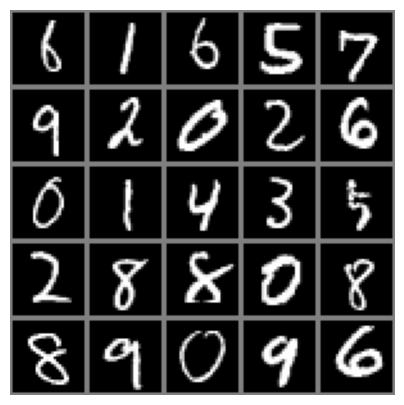

In [79]:
montage_plot(image_batch[0:25,0,:,:].cpu().detach().numpy()) #create a montage of the original images

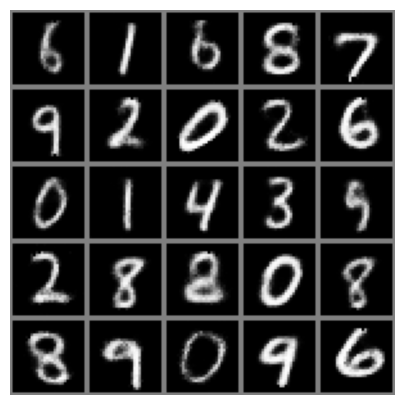

In [80]:
montage_plot(image_batch_recon[0:25,0,:,:].cpu().detach().numpy()) #create a montage of the reconstructed images to compare against the originals


### Generator



In [81]:
#set the sizes for the different layers of the neural network
latent_size = 64
hidden_size = 256
image_size = 784
b = 1024 #batch size

In [82]:
#MNIST
# train_set = MNIST('./data', train=True, download=True)
# test_set = MNIST('./data', train=False, download=True)

#KMNIST
#train_set = KMNIST('./data', train=True, download=True)
#test_set = KMNIST('./data', train=False, download=True)

#Fashion MNIST (loading)
train_set = FashionMNIST('./data', train=True, download=True)
test_set = FashionMNIST('./data', train=False, download=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 7988005.67it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 160356.90it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3020583.15it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3792776.57it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [83]:
X = train_set.data.numpy() #convert dataset images and labels to NumPy arrays
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255 #normalize the image pixel values to the range [0, 1]
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5 #normalize the images to have a mean of 0 and std of 1
X_test = (X_test - 0.5)/0.5

In [84]:
n = 7 #filter the datasets to only include images of the digit/class 7

index = np.where(Y == n)
X = X[index]
index = np.where(Y_test == n)
X_test = X_test[index]

In [85]:
X.shape,Y.shape,X_test.shape,Y_test.shape #print the shapes of the data arrays to verify dimensions

((6000, 1, 28, 28), (60000,), (1000, 1, 28, 28), (10000,))

In [86]:
###################################################

In [87]:
X = GPU_data(X) #transfer the data to the GPU for faster computation
X_test = GPU_data(X_test)
Y = GPU_data(Y)
Y_test = GPU_data(Y_test)

In [88]:
x,y = get_batch('train') #retrieve a batch of data for training

In [89]:
x.shape

torch.Size([1024, 1, 28, 28])

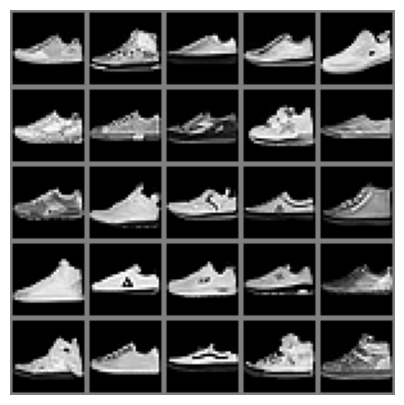

In [90]:
montage_plot(x[0:25,0,:,:].detach().cpu().numpy()) #visualize the first 25 images from the batch using a montage plot

In [91]:
#D define the neural network weights with random truncated normal initialization and transfer to GPU
w0 = GPU(randn_trunc((64,1,4,4))) #first convolutional layer weights
w1 = GPU(randn_trunc((128,64,4,4))) #second convolutional layer weights
w2 = GPU(randn_trunc((1,6272))) #weights for reshaping/flattening
#G
w3 = GPU(randn_trunc((6272,64))) #decoder weights for unflattening
w4 = GPU(randn_trunc((128,64,4,4))) #decoder convolutional layer weights
w5 = GPU(randn_trunc((64,1,4,4))) #final decoder convolutional layer weights

w = [w0,w1,w2,w3,w4,w5] #combine weights into a list

In [92]:
def D(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1))) #apply a series of convolutions and activations to input x using weights w
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272) #flatten the output
    x = linear(x,w[2]) #apply a linear layer
    x = torch.sigmoid(x) #apply sigmoid activation function
    return x

In [93]:
def G(x,w):
    #generate an image starting from latent vector x using weights w
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7) #reshape for deconvolution layers
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [94]:
b = 1024 #set batch size for training

In [95]:
batch_size = b

In [96]:
batch_size

1024

In [97]:
d_optimizer = torch.optim.Adam(w[0:3], lr=0.0002) #initialize optimizers for the discriminator and generator
g_optimizer = torch.optim.Adam(w[3:], lr=0.0002)

real_labels = (torch.ones(batch_size, 1).cuda()) #create labels for real and fake data
fake_labels = (torch.zeros(batch_size, 1).cuda())

In [98]:
num_epochs = 500 #calculate the number of batches and steps for the training loop
batches = X.shape[0]//batch_size
steps = num_epochs*batches

In [99]:
z1 = (torch.randn(steps,batch_size,latent_size).cuda()) #initialize latent vectors
z2 = (torch.randn(steps,batch_size,latent_size).cuda())

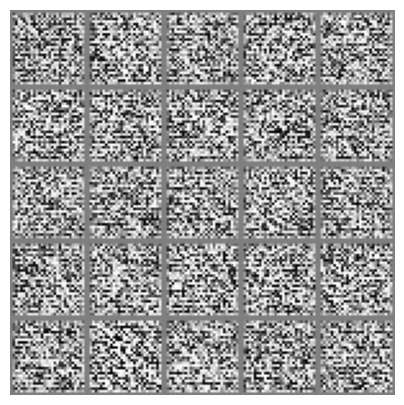

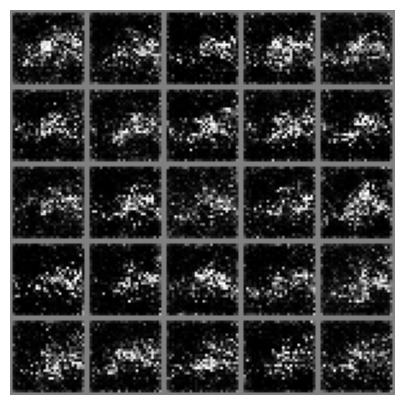

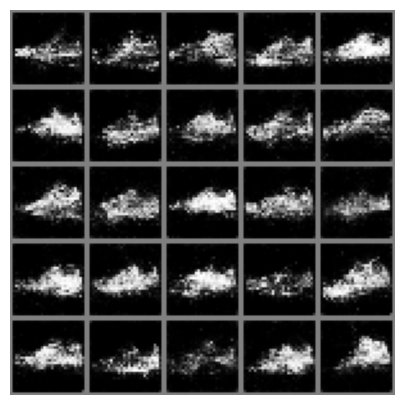

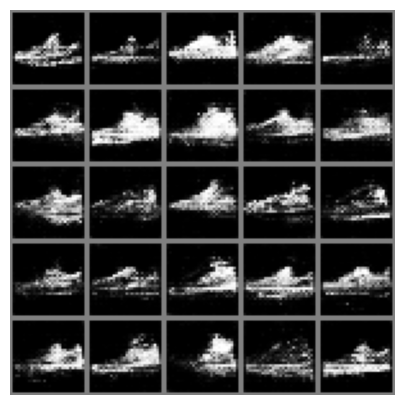

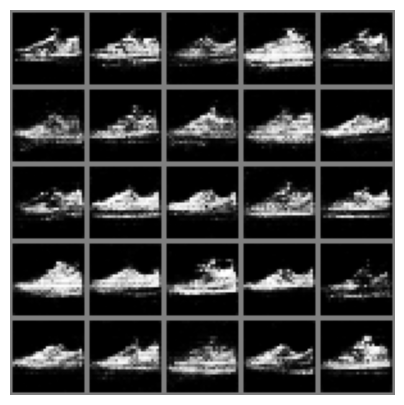

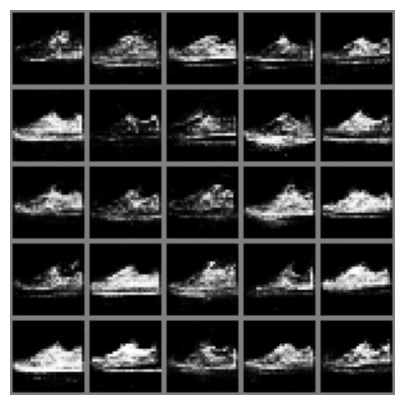

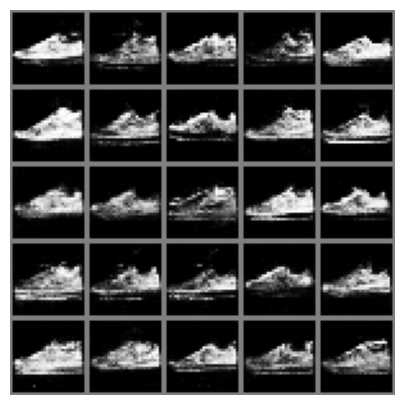

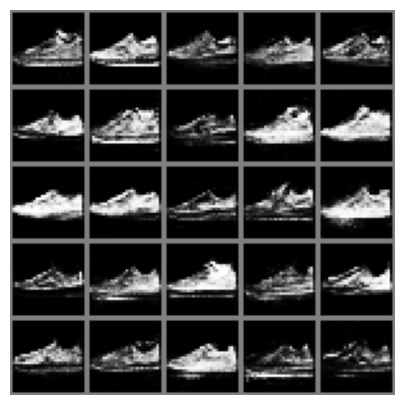

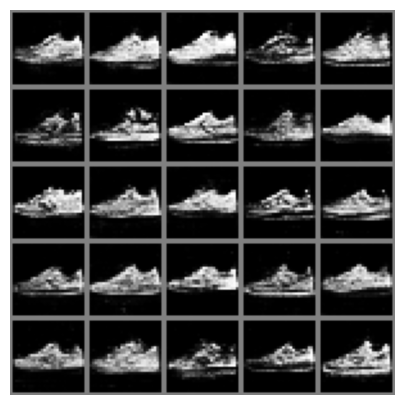

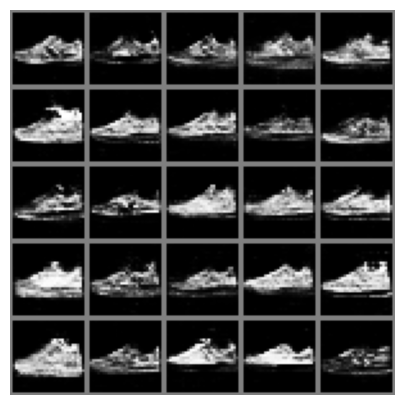

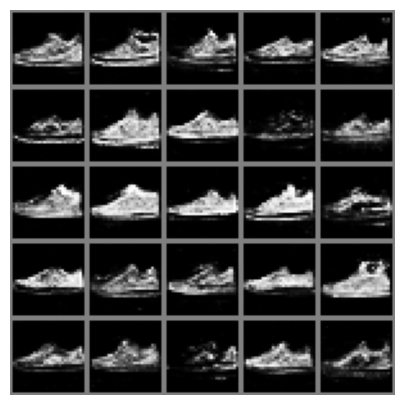

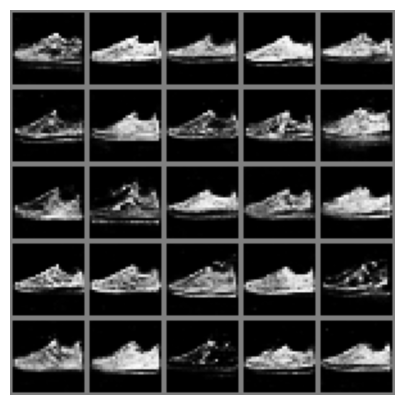

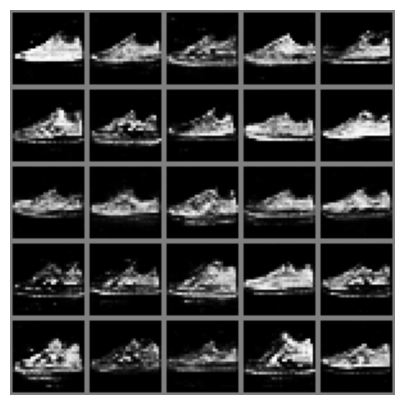

In [100]:
for i in range(steps):

    images,y = get_batch('train') #get a batch of real images

    d_loss = binary_cross_entropy(D(images,w), real_labels) + binary_cross_entropy(D(G(z1[i],w),w), fake_labels) #calculate loss for real and fake images
    d_optimizer.zero_grad() #reset gradients for the discriminator
    d_loss.backward() #back propagate the loss
    d_optimizer.step() #update the discriminator's weights


    g_loss = binary_cross_entropy(D(G(z2[i],w),w), real_labels) #calculate loss for generator
    g_optimizer.zero_grad() #reset gradients for the generator
    g_loss.backward() #backpropagate the loss
    g_optimizer.step() #update the generator's weights


    if i % 200 == 0: #every 200 steps, generate an image to visualize the generator's progress
        out = G(z1[np.random.randint(steps)],w)
        montage_plot(out.view(batch_size,1,28,28).detach().cpu().numpy()[0:25,0,:,:])

In [101]:
z1[np.random.randint(steps)].shape #select a random latent vector's shape to verify the tensor dimensions

torch.Size([1024, 64])

In [102]:
noise = GPU_data(torch.randn(1,64)) #generate a random latent vector and transfer it to the GPU

<ipython-input-19-3ed6eaf52084>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))


In [103]:
output = G(noise,w) #generate an output (fake image) using the generator network

In [104]:
output.shape #print the shape of the generated output to verify it's as expected

torch.Size([1, 1, 28, 28])

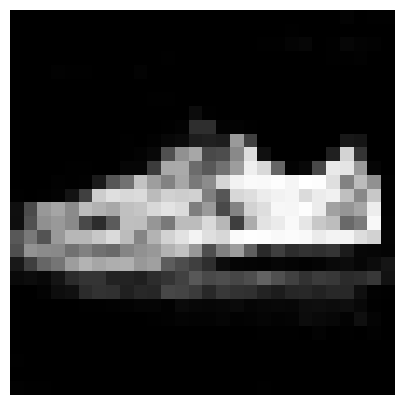

In [105]:
plot(output[0,0]) #plot the first example from the generated batch of outputs